# Discovering phases and ferroelectric domains

**Lets Install some usefull packages**

In [ ]:
# Installing Kornia and pyroved
!pip install -q kornia atomai git+https://github.com/ziatdinovmax/pyroVED@main
!pip install colorspacious
!pip install wget

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.4/899.4 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=7d6af5d1d488f4dc12cb56b736a146fe79878f344f07ccdf6490804965762fcf
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97

**Import libraries**

In [ ]:
from atomai import utils
from atomai import stat as atomstat
import atomai as aoi

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

In [ ]:
import gdown
import h5py
import wget
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import matplotlib.patches as patches

<span style="color: blue; font-size: 18px;"><strong>Download Dataset</strong></span>

This data set is the collection of high resolution electron microscopy images of the ferroelectric BiFeO3 doped with Sm. The samples were prepared as combinatorial library by Prof. Ichiro Takeuchi group (University of Maryland). The STEM data was taken and physics based analysis was performed by Dr. Chris Nelson (Oak Ridge). Data sharing enables downstream applications and is common in many scientific domains (structural data, thermodynamics, genomics, theoretical computational databases). It is an emerging trend in areas such as microscopy. Note that making data available is a part of FAIR principles and is now mandated by funding agencies in US (NSF, DOE, etc).  

Now, we have access to the SmBFO STEM image with Sm = 0, 7, 10, 13% compositions. Note that Sm = 0 composition is the pure rhombohedral ferroelectric, whereas high Sm concentrations are orthorhombic non-ferroelectric material. Since rhombohedral and orthorhombic phases are crystallograhically incompartible, the phases with intermediate Sm concentrations have to acocmodate this structural mismatch by forming complex nanoscale structures. In macroscopic scattering data, they can show period doubling, low-symmetry phases, etc. - however, their true nanoscale strucutre is understood only poorly. These morphotropic systems also have interesting macroscopic properties such as enhanced dielectric and electromechnical properties. So, let's dive in into atomic world of these systems!

In [ ]:
model_files = ['Sm_0_1_HAADF.h5',
               'Sm_0_1_UCParameterization.h5',
               'Sm_7_2_HAADF.h5',
               'Sm_7_2_UCParameterization.h5',
               'Sm_10_1_HAADF.h5',
               'Sm_10_1_UCParameterization.h5',
               'Sm_13_0_HAADF.h5',
               'Sm_13_0_UCParameterization.h5',
               'Sm_20_0_HAADF.h5',
               'Sm_20_0_UCParameterization.h5']

for model_file in model_files:
  print(model_file)
  wget.download("https://zenodo.org/record/4555979/files/"+model_file+"?download=1", out=model_file)

Sm_0_1_HAADF.h5
Sm_0_1_UCParameterization.h5
Sm_7_2_HAADF.h5
Sm_7_2_UCParameterization.h5
Sm_10_1_HAADF.h5
Sm_10_1_UCParameterization.h5
Sm_13_0_HAADF.h5
Sm_13_0_UCParameterization.h5
Sm_20_0_HAADF.h5
Sm_20_0_UCParameterization.h5


In [ ]:
#list files
filedir = '/content'
[f for f in os.listdir(filedir)]

['.config',
 'Sm_0_1_HAADF.h5',
 'Sm_0_1_UCParameterization.h5',
 'Sm_13_0_HAADF.h5',
 'Sm_7_2_HAADF.h5',
 'Sm_20_0_UCParameterization.h5',
 'Sm_10_1_HAADF.h5',
 'Sm_13_0_UCParameterization.h5',
 'Sm_7_2_UCParameterization.h5',
 'Sm_10_1_UCParameterization.h5',
 'Sm_20_0_HAADF.h5',
 'sample_data']

In [ ]:
#image files
composition_tags = [0,7,10,13,20]    #Sm composition %


img_filename = ['Sm_0_1_HAADF.h5',
                'Sm_7_2_HAADF.h5',
                'Sm_10_1_HAADF.h5',
                'Sm_13_0_HAADF.h5',
                'Sm_20_0_HAADF.h5',]

imnum = len(img_filename)

#parametrization files

UCparam_filename = ['Sm_0_1_UCParameterization.h5',
                    'Sm_7_2_UCParameterization.h5',
                    'Sm_10_1_UCParameterization.h5',
                    'Sm_13_0_UCParameterization.h5',
                    'Sm_20_0_UCParameterization.h5',]

#load parameter files
UCparam = []
for x in UCparam_filename:
  print('loading parameterization file: ', os.path.join(filedir, x))
  temp = h5py.File(os.path.join(filedir, x), 'r')
  UCparam.append(temp)

#load images
imgdata = []
for x in img_filename:
  print('loading image file: ', os.path.join(filedir, x))
  temp = h5py.File(os.path.join(filedir, x), 'r')['MainImage']
  imgdata.append(temp)

print('UC parameterization:', [k for k in UCparam[0].keys()])

loading parameterization file:  /content/Sm_0_1_UCParameterization.h5
loading parameterization file:  /content/Sm_7_2_UCParameterization.h5
loading parameterization file:  /content/Sm_10_1_UCParameterization.h5
loading parameterization file:  /content/Sm_13_0_UCParameterization.h5
loading parameterization file:  /content/Sm_20_0_UCParameterization.h5
loading image file:  /content/Sm_0_1_HAADF.h5
loading image file:  /content/Sm_7_2_HAADF.h5
loading image file:  /content/Sm_10_1_HAADF.h5
loading image file:  /content/Sm_13_0_HAADF.h5
loading image file:  /content/Sm_20_0_HAADF.h5
UC parameterization: ['I1', 'I2', 'I3', 'I4', 'I5', 'NCOM', 'PCOM', 'Pxy', 'Vol', 'a', 'ab', 'abdelta', 'alpha', 'atmindex', 'b', 'index', 'meanuca', 'meanucb', 'nbrUC', 'xy_COM', 'xy_atms']


- In addition to the raw STEM data, the parametrization files yield the information on each unit cell within the data that we can use as a physics-based comparison to ML analyses. For example, I1-5 are intensity of atomic columns, Vol is unit cell volume, Pxy are polarization components, and so on.
- Note that since the physics of these systems is not known exactly (that is why we are studying them!), ML can discover new phenomena that were not acocunted for in physics-based descriptors.
- Look though the code below and try to follow how we store and organize the data.  

In [ ]:
#function maps x,y grid positions into a matrix data format
def map2grid(inab, inVal):

  default_val = np.nan
  abrng = [int(np.min(inab[:,0])), int(np.max(inab[:,0])), int(np.min(inab[:,1])), int(np.max(inab[:,1]))]
  abind = inab
  abind[:,0] -= abrng[0]
  abind[:,1] -= abrng[2]
  Valgrid = np.empty((abrng[1]-abrng[0]+1,abrng[3]-abrng[2]+1))
  Valgrid[:] = default_val
  Valgrid[abind[:,0].astype(int),abind[:,1].astype(int)]=inVal[:]
  return Valgrid, abrng

In [ ]:
def plot_polarization_vectors(k):

    # Prepare vector components and positions
    X = k['ab_x'].ravel()
    Y = k['ab_y'].ravel()
    U = k['ab_Px'].ravel()
    V = k['ab_Py'].ravel()

    # Rotate coordinates 90 degrees counter-clockwise
    X_rot = -Y
    Y_rot = X

    # Invert y-axis
    Y_rot = -Y_rot

    # Rotate vector components
    U_rot = -V
    V_rot = U

    # Invert y-axis component of vectors
    V_rot = -V_rot

    # Compute magnitude and direction of the polarization vectors
    # Compute magnitude and direction of the polarization vectors
    Pmag = np.sqrt(U**2 + V**2)
    Pdir = np.arctan2(V, U)

    # Normalize magnitude for color scaling (clip at 90th percentile to avoid outliers)
    Pmag_norm = np.clip(Pmag / np.nanpercentile(Pmag, 90), 0, 1)

    # Define the colormap for mapping the direction and magnitude
    # Since 'papuc' may not be available, we'll use a built-in colormap

    # Normalize direction to [0, 1] for colormap mapping
    norm = Normalize(vmin=-np.pi, vmax=np.pi)
    cmap = cm.hsv  # Using HSV colormap to represent directions

    # Map direction to colors
    cP = cmap(norm(Pdir))

    # Alternatively, adjust colors based on magnitude if desired
    # For this simple example, we'll just use direction for color
    return Y, X, U, V, cP

In [ ]:
SBFOdata = []     #this will be the output list of dictionaries for each dataset

for i in np.arange(imnum):
  temp_dict = {'Index': i}
  temp_dict['Composition'] = composition_tags[i]
  temp_dict['Image'] = imgdata[i]
  temp_dict['Filename'] = img_filename[i]

  for k in UCparam[i].keys():       #add labels for UC parameterization
    temp_dict[k] = UCparam[i][k][()]

  #select values mapped to ab grid
  temp_dict['ab_a'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['ab'][()].T[:,0])[0]       #a array
  temp_dict['ab_b'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['ab'][()].T[:,1])[0]       #b array
  temp_dict['ab_x'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['xy_COM'][()].T[:,0])[0]   #x array
  temp_dict['ab_y'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['xy_COM'][()].T[:,1])[0]   #y array
  temp_dict['ab_Px'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['Pxy'][0])[0]             #Px array
  temp_dict['ab_Py'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['Pxy'][1])[0]        #Py array
  temp_dict['Vol'] = map2grid(UCparam[i]['ab'][()].T, UCparam[i]['Vol'])[0]     #Vol array

  SBFOdata.append(temp_dict)

Explore the structure of the SBFOdata object. Are the comments in the code sufficient to interpret what are the individual elements in it?

In [ ]:
SBFOdata[1].keys()

dict_keys(['Index', 'Composition', 'Image', 'Filename', 'I1', 'I2', 'I3', 'I4', 'I5', 'NCOM', 'PCOM', 'Pxy', 'Vol', 'a', 'ab', 'adelta', 'alpha', 'atmindex', 'b', 'bdelta', 'index', 'meanuca', 'meanucb', 'nbrUC', 'xy_COM', 'xy_atms', 'ab_a', 'ab_b', 'ab_x', 'ab_y', 'ab_Px', 'ab_Py'])

In [ ]:
SBFOdata[1]['ab_a'].shape

(166, 155)

Now, let's visualize the images and corresponding distributions of polarization components Px, Py, and unit cell volume Vol

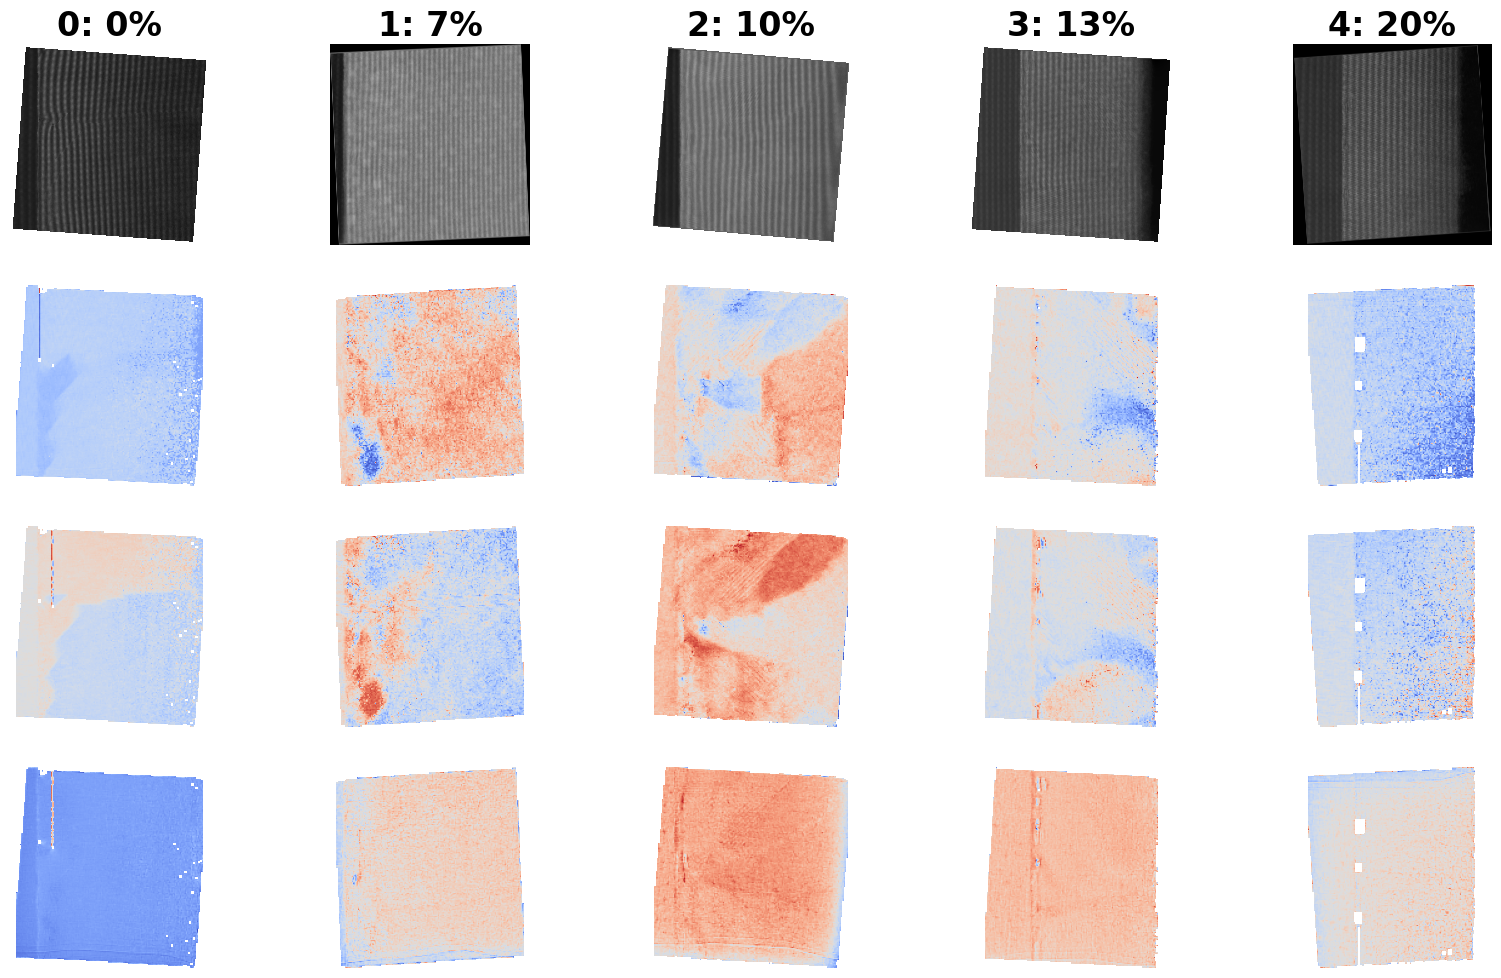

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=len(SBFOdata), figsize=(4*len(SBFOdata), 4*3), dpi=100)
for i, k in enumerate(SBFOdata):
  #Image
  ax[0,i].imshow(k['Image'], origin='upper', cmap='gray')
  ax[0,i].set_title(str(k['Index'])+': '+str(k['Composition'])+'%', fontsize = 24, fontweight = "bold")
  ax[0,i].set_axis_off()
  #Px
  ax[1,i].imshow(k['ab_Px'], origin='upper', cmap='coolwarm')
  ax[1,i].set_axis_off()
  #Py
  ax[2,i].imshow(k['ab_Py'], origin='upper', cmap='coolwarm')
  ax[2,i].set_axis_off()

  # Vol (added row to display Vol)
  ax[3, i].imshow(k['Vol'], origin='upper', cmap='coolwarm')
  ax[3, i].set_axis_off()

As you can see, for low Sm concentrations the olarization maps show clear ordered ferroelectric domains.On increasing Sm concentration, they become more disordered and then disappear for 20% Sm. Also note that unit cell volume map shows (some) variation between material and substrate, does not show variations associated with the domains, and also shows smooth changes across the image plane. The latter are associated with non-ideality of the microscope (the mis-tilt effects).

You can also note the missing regions on the last image. These correspond to the regions that contained growth defects and were removed during the curation of the data set.

## **Problem 1:** Classification of ferroic domains

Now, let's experiment with the practical problem.
- Let's assume that we **know** the phase/ferroic orientation in several regions of the material. These will be our labels.
- Given these labels, we would like to classify the remaining parts of the image.
- However, for the time being we also **do not** have any information about atomic positions, physical order parameter fields, etc. All we have access to is the image data. Can we classify the regions in the image given small amount of known labels?

Let's do it for pure BFO (with well defined domains), corresponding to imgdata[0]. We will use the sliding window approach, representing the image as a collection of image patches of certain size taken from the grid of points. Explore the code below to identify how this is done.


In [ ]:
img_array = np.array(imgdata[0])
scaler = preprocessing.StandardScaler().fit(img_array)
scaler.mean_
scaler.scale_
X_scaled = scaler.transform(img_array)

window_size = 40
step_size = 20

# Generate a grid of coordinates based on the step size
coordinates = aoi.utils.get_coord_grid(X_scaled, step_size)

# Extract the coordinates from the first element (assuming it's the desired set)
coords = coordinates[0]

# Extract subimages, centers of mass, and frame numbers based on the generated grid
imstack_grid, com_grid, frames_grid = aoi.utils.extract_subimages(X_scaled, coords, window_size)

# Output the shape of the extracted image stack
print(imstack_grid.shape)
print(com_grid.shape)
print(frames_grid.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


(40192, 40, 40, 1)
(40192, 2)
(40192,)


Below, we
- Create array of the same length as coordinate and patches filled by zeros
- Identify spatial regions that are substrate, domain 1, 2, and 3
- For coordinates that fall within these, we change labels from 0 to 1,2,3 respectively.

With that, we will have coordinate array, patch array, and label array where 1,2,3 are known labels and 0 are unknown labels. And they can experiment with window sizes and all arrays will be recalculated.


In [ ]:
# Initialize a label array of zeros
label_array = np.zeros(len(com_grid), dtype=int)

In [ ]:
# Define spatial regions (
substrate_region = [3000, 3150, 400, 550]  # Substrate region
domain1_region = [2000, 2150, 1000, 1150]  # Domain 1 region
domain2_region = [3000, 3150, 2000, 2150]  # Domain 2 region
domain3_region = [1000, 1150, 2000, 2150]  # Domain 3 region

In [ ]:
# Ensure that com_grid and label_array are of the same size before processing
if len(label_array) != len(com_grid):
    raise ValueError("label_array and com_grid must have the same length!")

# Assign labels based on the coordinates falling within the regions
for i, (x, y) in enumerate(com_grid):
    if substrate_region[0] <= x <= substrate_region[1] and substrate_region[2] <= y <= substrate_region[3]:
        label_array[i] = 1  # Substrate
    elif domain1_region[0] <= x <= domain1_region[1] and domain1_region[2] <= y <= domain1_region[3]:
        label_array[i] = 2  # Domain 1
    elif domain2_region[0] <= x <= domain2_region[1] and domain2_region[2] <= y <= domain2_region[3]:
        label_array[i] = 3  # Domain 2
    elif domain3_region[0] <= x <= domain3_region[1] and domain3_region[2] <= y <= domain3_region[3]:
        label_array[i] = 4  # Domain 3

# Output the label array and its distribution to check the correctness
print("Label array:", label_array)
print("Distribution of labels:", np.unique(label_array, return_counts=True))

# Ensure that label_array, com_grid, and imstack_grid are aligned in size
print("Coordinates shape (com_grid):", com_grid.shape)
print("Image stack shape (imstack_grid):", imstack_grid.shape)
print("Label array shape:", label_array.shape)

Label array: [0 0 0 ... 0 0 0]
Distribution of labels: (array([0, 1, 2, 3, 4]), array([39936,    64,    64,    64,    64]))
Coordinates shape (com_grid): (40192, 2)
Image stack shape (imstack_grid): (40192, 40, 40, 1)
Label array shape: (40192,)


This is our label array. The region 0 are unknown, the regions 1,2,3, and 4 are known labels.

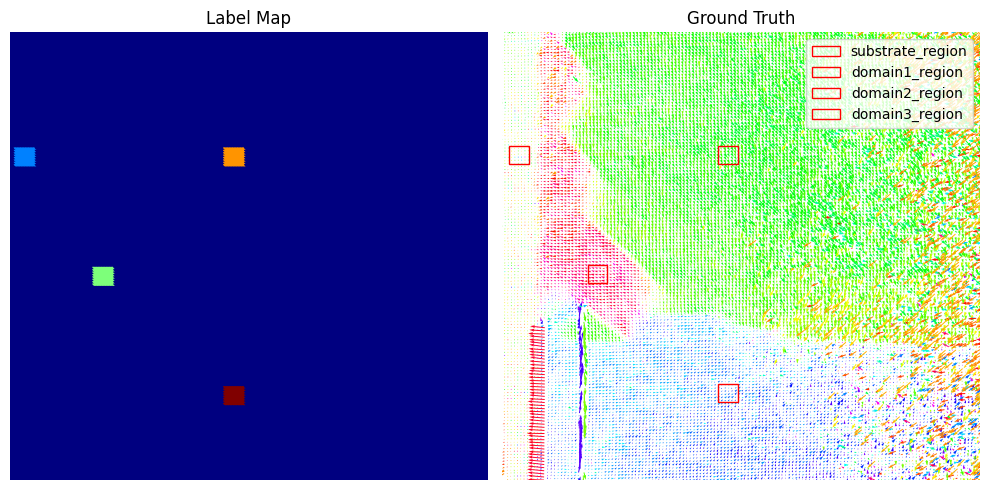

In [ ]:
# Example regions to mark on the plot
regions = {
    'substrate_region': (400, 3000, 150, 150),
    'domain1_region': (2000, 1000, 150, 150),
    'domain2_region': (2000, 3000, 150, 150),
    'domain3_region': (1000, 2000, 150, 150)
}

# Assuming 'main' and 'SBFOdata' are defined
main = [350, 4000, 350, 4100]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Visualize the label map on the first subplot
axes[0].scatter(com_grid[:, 1], com_grid[:, 0], c=label_array, cmap='jet', s=10)
axes[0].set_title('Label Map')
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')
axes[0].invert_yaxis()
axes[0].axis("off")
axes[0].set_xlim(main[0], main[1])
axes[0].set_ylim(main[2], main[3])

# Plot the polarization vectors on the second subplot
k = SBFOdata[0]  # Assuming SBFOdata is well defined with necessary keys
Y, X, U, V, cP = plot_polarization_vectors(k)
axes[1].quiver(Y, X, U, V, color=cP, scale=0.1, angles='xy', scale_units='xy', width=0.002)
axes[1].set_title('Ground Truth')
axes[1].set_xlim(main[0], main[1])
axes[1].set_ylim(main[2], main[3])
axes[1].axis("off")

# Add regions as rectangles on the second subplot
for region_name, (x, y, width, height) in regions.items():
    # Create a rectangle at each region
    rect = Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none', label=region_name)
    axes[1].add_patch(rect)

# Optionally, add a legend if needed
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
# Split the labeled and unlabeled data
labeled_indices = np.where(label_array > 0)[0]  # Indices where labels are known
unlabeled_indices = np.where(label_array == 0)[0]  # Indices where labels are unknown

# Prepare the training data (patches and labels)
X_train = imstack_grid[labeled_indices]  # Known patches (train data)
y_train = label_array[labeled_indices]  # Corresponding labels (1, 2, 3)

# Prepare the test data (patches without labels)
X_test = imstack_grid[unlabeled_indices]  # Patches for unknown labels (test data)
# Check if there are any unknown labels (0s) in the label_array
print(f"Number of unlabeled data points: {np.sum(label_array == 0)}")

# Flatten patches (if needed) for RandomForest input
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten for training
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Flatten for testing

print(f"Number of unlabeled data points: {np.sum(label_array == 1)}")

Number of unlabeled data points: 39936
Number of unlabeled data points: 64


Problem 1a:
- define several classifiers
- classify the unknown points
- make the map of the class labels for each classifier
- create average class labels and uncertainty map based on multiple classifiers.

Problem 1b:
- Choose one classifier
- Explore the effect of the window size on classification

Problem 1c:
- For the regions outside of the labeled ones, we do not have access to the ground truth data (so we can define confusion matrix/ROC/AUC only **within** labeled regions)
- However, we do have access to ground truth data (Px,Py, Vol) and all other descriptors
- Suggest a startegy to estimate the quality of classification if the ground truth labels are not available, but we have access to (Px,Py, Vol). Realize it for one classifier.

## **Problem 2:** Unsupervised exploration

Now, let's explore one of the intermediate concentrations of Sm images using sliding window approach. Let's proceed as following:
- Import one of the images for the intermediate concentrations that show the presence of ferroelectric and ordered phases. Choose an image!
- Create a standard data sets, meaning coordinate array and matching array of patches. Here we add additional degree of freedom by allowing the window to be rectangular, (w1,w2).
- Let's  explore clustering given the patches, and explore window size effects

Custom function for chosing rectangular windows

In [ ]:
def custom_subimages(imgdata, step_size, window_size):
    # Generate coordinates based on step size
    height, width = imgdata.shape[:2]
    x_coords = np.arange(0, height - window_size[0] + 1, step_size)
    y_coords = np.arange(0, width - window_size[1] + 1, step_size)
    coordinates = [(x, y) for x in x_coords for y in y_coords]

    # Extract subimages of the specified window size
    half_height = window_size[0] // 2
    half_width = window_size[1] // 2
    subimages_target = []
    coms_target = []
    removed_due_to_size = 0
    removed_due_to_nans = 0

    for coord in coordinates:
        cx, cy = coord
        top = max(cx - half_height, 0)
        bottom = min(cx + half_height, height)
        left = max(cy - half_width, 0)
        right = min(cy + half_width, width)

        subimage = imgdata[top:bottom, left:right]

        if subimage.shape != tuple(window_size):
            removed_due_to_size += 1
        elif np.isnan(subimage).any():
            removed_due_to_nans += 1
        else:
            subimages_target.append(subimage)
            coms_target.append(coord)

    print("Number of subimages removed due to size mismatch:", removed_due_to_size)
    print("Number of subimages removed due to NaNs:", removed_due_to_nans)

    return np.array(subimages_target), np.array(coms_target)

In [ ]:
window_size = (12, 20)
step_size = 12

imstack_grid, com_grid = custom_subimages(imgdata[0], step_size, window_size)

print(imstack_grid.shape)
print(com_grid.shape)

Number of subimages removed due to size mismatch: 736
Number of subimages removed due to NaNs: 21977
(113073, 12, 20)
(113073, 2)


Problem 2a:
- Select image and window size
- Cluster the image patches
- Visualize the labels map
- Estimate the required number of clusters


Problem 2b:
- Let's assume that we want to compare multiple clustering approaches. The problem is that cluster labels are assigned randomly, meaning (0,1,2) in one lcustering method will not match the labels from other method
- Suggest and realize approach to align the labels between different clustering methods

Problem 2c:
- Realize 3 different clustering methods of the data
- Align the labels
- Plot the average and uncertainty maps